(666, 499, 3)

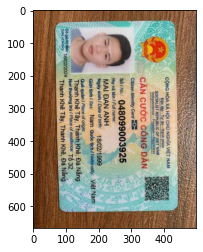

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

def read_img_as_array(img_path):
    image = Image.open(img_path)
    return np.asarray(image)

image = read_img_as_array('C:/Users/Admin/Desktop/A.N lab/test_imgs-raw/cccd2.jpg')

plt.imshow(image)
image.shape

# Alignment
- for 4 corners coordinates

## Roboflow API 

In [ ]:
import cv2
import supervision as sv
from roboflow import Roboflow
from supervision import BoxAnnotator

rf = Roboflow(api_key="JSVeJAx7mmzoT48naM0W")
project = rf.workspace().project("4corners-gwkuc")
model = project.version(5).model

def get_corners(result):
    detection_boxes = []
    detection_classes = []
    category_index = {}

    for prediction in result['predictions']:
        x_center = prediction['x']
        y_center = prediction['y']
        width = prediction['width']
        height = prediction['height']
        class_id = prediction['class_id'] + 1
        class_name = prediction['class']

        x1 = x_center - (width/2)
        y1 = y_center - (height/2)
        x2 = x_center + (width/2)
        y2 = y_center + (height/2)

        # Convert the bounding box coordinates to the format [y01, x01, y02, x02]
        # detection_boxes.append([y, x, y + height, x + width])
        detection_boxes.append([y1, x1, y2, x2])
        detection_classes.append(class_id)
        category_index[class_id] = {'id': class_id, 'name': class_name}

    detection_boxes = np.array(detection_boxes) # casting as array
    detection_classes = np.array(detection_classes).astype('float') # float converting
    
    return detection_boxes, detection_classes, category_index

result = model.predict(image, confidence=50, overlap=30).json()

# result

## YOLOv8 inference


image 1/1 C:\Users\Admin\Desktop\A.N lab\test_imgs-raw\cccd4.jpg: 640x288 1 botleft, 1 botright, 1 topleft, 1 topright, 163.8ms
Speed: 1.6ms preprocess, 163.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 288)

 detection_boxes: 
 [[     406.66      276.58      472.62      341.02]
 [     418.78      876.72      514.33      968.29]
 [      10.35      261.85      96.931      332.26]
 [     32.302      921.58       115.4      997.54]] 
 detection_classes: 
 [          2           3           0           1] 
 Confidence: 
 [    0.87616     0.81165     0.74578     0.72662] 
 category_index: 
 {0: 'botleft', 1: 'botright', 2: 'topleft', 3: 'topright'}


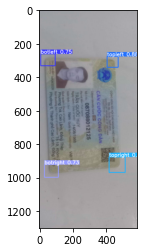

In [8]:
from ultralytics import YOLO

# Load a model
model = YOLO('C:/Users/Admin/Desktop/A.N lab/KIE/weights/YOLOv8n_4corners_v1.pt')  # pretrained YOLOv8n model

results = model.predict(source='C:/Users/Admin/Desktop/A.N lab/test_imgs-raw/cccd4.jpg', conf=0.5)

print(
    f'\n detection_boxes: \n {np.array(results[0].boxes.xyxy)}',
    f'\n detection_classes: \n {np.array(results[0].boxes.cls)}',
    f'\n Confidence: \n {np.array(results[0].boxes.conf)}',
    f'\n category_index: \n {model.model.names}',

)
plt.imshow(results[0].plot())
# results[0].show()

## 4 corners scaling 
- detection test on multiple images 

### Alignment helper function

In [4]:
def _get_center_point(coordinate_dict):
    di = dict()

    for key in coordinate_dict.keys():
        xmin, ymin, xmax, ymax = coordinate_dict[key]
        x_center = (xmin + xmax) / 2
        y_center = (ymin + ymax) / 2
        di[key] = (x_center, y_center)

    return di


def _find_miss_corner(coordinate_dict):
    position_name = ['top_left', 'top_right', 'bottom_left', 'bottom_right']
    position_index = np.array([0, 0, 0, 0])

    for name in coordinate_dict.keys():
        if name in position_name:
            position_index[position_name.index(name)] = 1

    index = np.argmin(position_index)

    return position_name[index]


def _calculate_missed_coord_corner(coordinate_dict):
    thresh = 0

    index = _find_miss_corner(coordinate_dict)

    # calculate missed corner coordinate
    # case 1: missed corner is "top_left"
    if index == 'top_left':
        midpoint = np.add(coordinate_dict['top_right'], coordinate_dict['bottom_left']) / 2
        y = 2 * midpoint[1] - coordinate_dict['bottom_right'][1] - thresh
        x = 2 * midpoint[0] - coordinate_dict['bottom_right'][0] - thresh
        coordinate_dict['top_left'] = (x, y)
    elif index == 'top_right':  # "top_right"
        midpoint = np.add(coordinate_dict['top_left'], coordinate_dict['bottom_right']) / 2
        y = 2 * midpoint[1] - coordinate_dict['bottom_left'][1] - thresh
        x = 2 * midpoint[0] - coordinate_dict['bottom_left'][0] - thresh
        coordinate_dict['top_right'] = (x, y)
    elif index == 'bottom_left':  # "bottom_left"
        midpoint = np.add(coordinate_dict['top_left'], coordinate_dict['bottom_right']) / 2
        y = 2 * midpoint[1] - coordinate_dict['top_right'][1] - thresh
        x = 2 * midpoint[0] - coordinate_dict['top_right'][0] - thresh
        coordinate_dict['bottom_left'] = (x, y)
    elif index == 'bottom_right':  # "bottom_right"
        midpoint = np.add(coordinate_dict['bottom_left'], coordinate_dict['top_right']) / 2
        y = 2 * midpoint[1] - coordinate_dict['top_left'][1] - thresh
        x = 2 * midpoint[0] - coordinate_dict['top_left'][0] - thresh
        coordinate_dict['bottom_right'] = (x, y)

    return coordinate_dict


def _perspective_transform(image, source_points):
    dest_points = np.float32([[0, 0], [1000, 0], [1000, 600], [0, 600]])
    M = cv2.getPerspectiveTransform(source_points, dest_points)
    dst = cv2.warpPerspective(image, M, (1000, 600))
    # dst = cv2.warpPerspective(image, M, (image.shape[1], image.shape[0]))

    return dst


def align_image(image, coordinate_dict):
    # Interpolate if just have 3 points
    if len(coordinate_dict) < 3:
        # raise ValueError('Image may be right angle! or Please try again')
        print('Image may be right angle! or Please try again')
        return image, False

    # convert (xmin, ymin, xmax, ymax) to (x_center, y_center)
    coordinate_dict = _get_center_point(coordinate_dict)

    if len(coordinate_dict) == 3:
        coordinate_dict = _calculate_missed_coord_corner(coordinate_dict)

    top_left_point = coordinate_dict['top_left']
    top_right_point = coordinate_dict['top_right']
    bottom_right_point = coordinate_dict['bottom_right']
    bottom_left_point = coordinate_dict['bottom_left']

    source_points = np.float32([top_left_point, top_right_point, bottom_right_point, bottom_left_point])

    # align and crop image
    crop = _perspective_transform(image, source_points)

    return crop, True


#### Corners detection test (one, multiple)

##### Corner detector class (in progress)

loading Roboflow workspace...
loading Roboflow project...


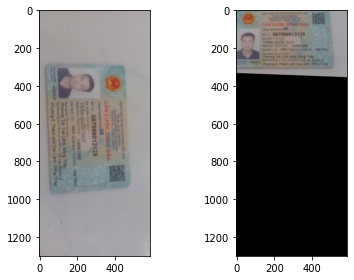

In [26]:
import supervision as sv
from roboflow import Roboflow
from supervision import BoxAnnotator

class CornerDetector():
    def __init__(self):
        self.model = self._load_model()
    
    @staticmethod
    def _load_model():
        rf = Roboflow(api_key="JSVeJAx7mmzoT48naM0W")
        project = rf.workspace().project("4corners-gwkuc")
        return project.version(5).model


    def _get_corners(self, result):
        ''' Get 4 points from JSON Roboflow result
        Args: JSON
        Output: 
        - corner detected boxes
        - corresponding classes/indexs (each box)
        - category index
        '''
        ## Get detection boxes, detection classes from Roboflow result
        detection_boxes = []
        detection_classes = []
        category_index = {}

        for prediction in result['predictions']:
            x_center = prediction['x']
            y_center = prediction['y']
            width = prediction['width']
            height = prediction['height']
            class_id = prediction['class_id'] + 1
            class_name = prediction['class']

            x1 = x_center - (width/2)
            y1 = y_center - (height/2)
            x2 = x_center + (width/2)
            y2 = y_center + (height/2)

            # Convert the bounding box coordinates to the format [y01, x01, y02, x02]
            detection_boxes.append([y1, x1, y2, x2])
            detection_classes.append(class_id)
            category_index[class_id] = {'id': class_id, 'name': class_name}

        detection_boxes = np.array(detection_boxes) # casting as array
        detection_classes = np.array(detection_classes).astype('float') # float converting
        
        return detection_boxes, detection_classes, category_index

    
    def transform_based_corner_detect(self, image):
        result = self.model.predict(image, confidence=40, overlap=30).json()

        # Call the function with the result JSON
        detection_boxes, detection_classes, category_index = self._get_corners(result)

        # print('Detection boxes, detection classes and category index respectively',
        #         detection_boxes, detection_classes, category_index)

        # print(f'Detection boxed: \n {detection_boxes},'
        #         f'\n Detection classes: \n {detection_classes}')

        coordinate_dict = dict()
        height, width, _ = image.shape

        for i in range(len(detection_classes)):
            label = str(category_index[detection_classes[i]]['name'])
            real_ymin = int(max(1, detection_boxes[i][0]))
            real_xmin = int(max(1, detection_boxes[i][1]))
            real_ymax = int(min(height, detection_boxes[i][2]))
            real_xmax = int(min(width, detection_boxes[i][3]))
            coordinate_dict[label] = (real_xmin, real_ymin, real_xmax, real_ymax)

        coordinate_dict = {
        key.replace('topleft', 'top_left').replace('topright', 'top_right').replace('botleft', 'bottom_left').replace('botright', 'bottom_right'): value for key, value in coordinate_dict.items()}

        # print(f'Coordinate dict: \n {coordinate_dict}')

        # align image
        cropped_img, done = align_image(image, coordinate_dict)

        return cropped_img, done    

    def draw_corner_detected(self, original, coordinate_dict):
        corner_img = np.copy(original)
        for name, box in coordinate_dict.items():
            start_point = (box[0], box[1])
            end_point = (box[2], box[3])
            color = (0, 255, 0)
            cv2.rectangle(corner_img, start_point, end_point, color, 2) 

            # Draw label
            label = str(name)
            cv2.putText(corner_img, label, (start_point[0], start_point[1]), cv2.FONT_HERSHEY_SIMPLEX, color=(0, 0, 255),
                fontScale=0.5)
            
        return corner_img
cornerDetector = CornerDetector()
corner_img = CornerDetector()
cropped_img, done = cornerDetector.transform_based_corner_detect(image)

#### VISUALIZATION: Original vs cropped plot
# Create a figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2)  # 1 row, 2 columns

# Display images in subplots
ax1.imshow(image)
ax2.imshow(cropped_img)

# Adjust layout (optional)
plt.tight_layout()

# Show the plot
plt.show()

##### One img test (Roboflow)

loading Roboflow workspace...
loading Roboflow project...


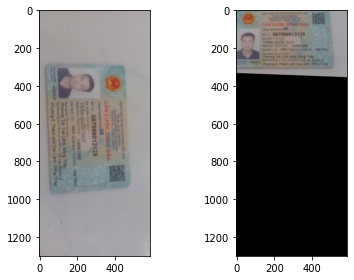

In [27]:
import supervision as sv
from roboflow import Roboflow
from supervision import BoxAnnotator

rf = Roboflow(api_key="JSVeJAx7mmzoT48naM0W")
project = rf.workspace().project("4corners-gwkuc")
model = project.version(5).model

## Get detection boxes, detection classes from Roboflow result
def get_corners(result):
    detection_boxes = []
    detection_classes = []
    category_index = {}

    for prediction in result['predictions']:
        x_center = prediction['x']
        y_center = prediction['y']
        width = prediction['width']
        height = prediction['height']
        class_id = prediction['class_id'] + 1
        class_name = prediction['class']

        x1 = x_center - (width/2)
        y1 = y_center - (height/2)
        x2 = x_center + (width/2)
        y2 = y_center + (height/2)

        # Convert the bounding box coordinates to the format [y01, x01, y02, x02]
        detection_boxes.append([y1, x1, y2, x2])
        detection_classes.append(class_id)
        category_index[class_id] = {'id': class_id, 'name': class_name}

    detection_boxes = np.array(detection_boxes) # casting as array
    detection_classes = np.array(detection_classes).astype('float') # float converting
    
    return detection_boxes, detection_classes, category_index

def transform_based_corner_detect(image):
    """
    Args: image
    Return: transformed img
    - 
    - 
    """
    result = model.predict(image, confidence=40, overlap=30).json()
    # print(result)

    # Call the function with the result JSON
    detection_boxes, detection_classes, category_index = get_corners(result)

    # print('Detection boxes, detection classes and category index respectively',
    #         detection_boxes, detection_classes, category_index)

    # print(f'Detection boxed: \n {detection_boxes},'
    #         f'\n Detection classes: \n {detection_classes}')

    coordinate_dict = dict()
    height, width, _ = image.shape

    for i in range(len(detection_classes)):
        label = str(category_index[detection_classes[i]]['name'])
        real_ymin = int(max(1, detection_boxes[i][0]))
        real_xmin = int(max(1, detection_boxes[i][1]))
        real_ymax = int(min(height, detection_boxes[i][2]))
        real_xmax = int(min(width, detection_boxes[i][3]))
        coordinate_dict[label] = (real_xmin, real_ymin, real_xmax, real_ymax)

    coordinate_dict = {
    key.replace('topleft', 'top_left').replace('topright', 'top_right').replace('botleft', 'bottom_left').replace('botright', 'bottom_right'): value for key, value in coordinate_dict.items()}

    # print(f'Coordinate dict: \n {coordinate_dict}')

    # align image
    cropped_img, done = align_image(image, coordinate_dict)

    return cropped_img, done

cropped_img, done = transform_based_corner_detect(image)

#### VISUALIZATION: Original vs cropped plot
# Create a figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2)  # 1 row, 2 columns

# Display images in subplots
ax1.imshow(image)
ax2.imshow(cropped_img)

# Adjust layout (optional)
plt.tight_layout()

# Show the plot
plt.show()

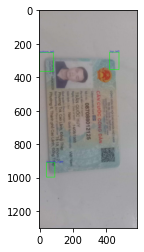

In [22]:
def draw_text_detected(cropped_img, coordinate_dict):
    cr_img = np.copy(cropped_img)
    for name, box in coordinate_dict.items():
        start_point = (box[0], box[1])
        end_point = (box[2], box[3])
        color = (0, 255, 0)
        img = cv2.rectangle(cr_img, start_point, end_point, color, 2) 

        # Draw label
        label = str(name)
        cv2.putText(cr_img, label, (start_point[0], start_point[1]), cv2.FONT_HERSHEY_SIMPLEX, color=(0, 0, 255),
            fontScale=0.5)
        
    return cr_img

# align image
corner_detected_img = draw_text_detected(image, coordinate_dict)
plt.imshow(corner_detected_img)

##### One img test (YOLOv8 ver)


image 1/1 C:\Users\Admin\Desktop\A.N lab\test_imgs-raw\cccd2.jpg: 640x480 1 botright, 1 topleft, 1 topright, 323.2ms
Speed: 8.0ms preprocess, 323.2ms inference, 14.5ms postprocess per image at shape (1, 3, 640, 480)


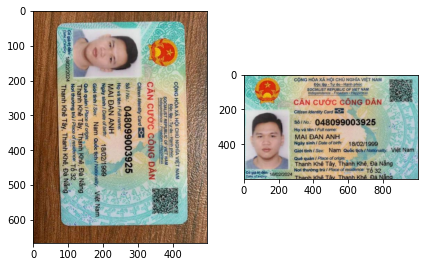

In [8]:
from ultralytics import YOLO

# Load a model
model = YOLO('C:/Users/Admin/Desktop/A.N lab/KIE/weights/YOLOv8n_4corners_v1.pt')  # pretrained YOLOv8n model
# category_index = model.model.names

def _get_coordinate_dict(image, detection_boxes, detection_classes, category_index):
    """
    Args: image
    Return: transformed img by
    - Perspective transforming from 4 corners 
    (including cropping via output size of OpenCV func)
    """
    
    # eliminate outliers (if exist)
    coordinate_dict = dict()
    height, width, _ = image.shape

    for i in range(len(detection_classes)):
        label = str(category_index[detection_classes[i]])
        real_xmin = int(max(1, detection_boxes[i][0]))
        real_ymin = int(max(1, detection_boxes[i][1]))
        real_xmax = int(min(width, detection_boxes[i][2]))
        real_ymax = int(min(height, detection_boxes[i][3]))
        coordinate_dict[label] = (real_xmin, real_ymin, real_xmax, real_ymax)

    coordinate_dict = {
    key.replace('topleft', 'top_left').replace('topright', 'top_right').replace('botleft', 'bottom_left').replace('botright', 'bottom_right'): value for key, value in coordinate_dict.items()}

    return coordinate_dict

def _corners_detection_inference(model, img_path):
    results = model.predict(source=img_path, conf=0.5)
    detection_boxes = np.array(results[0].boxes.xyxy)
    detection_classes = np.array(results[0].boxes.cls)

    return detection_boxes, detection_classes

#### One image at a time with YOLO
def align_based_corners_detect(model, img_path):
    ''' Alignment (rotate and crop) based 4 corners output by Corner detector
    Args: 
        - Model: instance of Corner detector
        - image path: path to local image
    Return:
        - aligned img
    
    '''
    img = read_img_as_array(img_path)

    # Output of corner detector
    detection_boxes, detection_classes = _corners_detection_inference(model, img_path)
    category_index = model.model.names

    # preprocessing output -> encapsulate into a dictionary
    coordinate_dict = _get_coordinate_dict(img, detection_boxes, detection_classes, category_index)
    
    # Aligning transformation
    cropped_img, done = align_image(img, coordinate_dict)

    return cropped_img, done

img_path = 'C:/Users/Admin/Desktop/A.N lab/test_imgs-raw/cccd2.jpg'
image = read_img_as_array(img_path) # read img
cropped_img, done = align_based_corners_detect(model, img_path) # alignment

#### VISUALIZATION: Original vs cropped plot
# Create a figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2)  # 1 row, 2 columns

# Display images in subplots
ax1.imshow(image)
ax2.imshow(cropped_img)

# Adjust layout (optional)
plt.tight_layout()

# Show the plot
plt.show()

##### Draw corners func

image 1/1 C:\Users\Admin\Desktop\A.N lab\test_imgs-raw\cccd2.jpg: 640x480 1 botright, 1 topleft, 1 topright, 340.4ms
Speed: 0.0ms preprocess, 340.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)
 
 Coordinates dictionary 
 : {'bottom_right': (70, 584, 109, 625), 'top_right': (412, 575, 456, 622), 'top_left': (412, 26, 440, 65)}


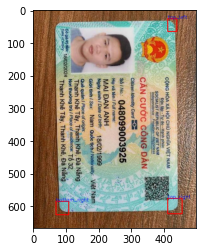

In [15]:
#### One image predicting with YOLO
def get_coordinate_dict(image, detection_boxes, detection_classes, category_index):
    """
    Args: image
    Return: transformed img by
    - Perspective transforming from 4 corners
    - Crop (in progress)
    """
    
    # eliminate outliners (if exist)
    coordinate_dict = dict()
    height, width, _ = image.shape

    for i in range(len(detection_classes)):
        label = str(category_index[detection_classes[i]])
        real_xmin = int(max(1, detection_boxes[i][0]))
        real_ymin = int(max(1, detection_boxes[i][1]))
        real_xmax = int(min(width, detection_boxes[i][2]))
        real_ymax = int(min(height, detection_boxes[i][3]))
        coordinate_dict[label] = (real_xmin, real_ymin, real_xmax, real_ymax)

    coordinate_dict = {
    key.replace('topleft', 'top_left').replace('topright', 'top_right').replace('botleft', 'bottom_left').replace('botright', 'bottom_right'): value for key, value in coordinate_dict.items()}

    return coordinate_dict

# Output of corner detector
detection_boxes, detection_classes = _corners_detection_inference(model, img_path)
category_index = model.model.names
coordinate_dict = get_coordinate_dict(image, detection_boxes, detection_classes, category_index)
print(f' \n Coordinates dictionary \n : {coordinate_dict}')

def draw_text_detected(cropped_img, coordinate_dict):
    cr_img = np.copy(cropped_img)
    for name, box in coordinate_dict.items():
        start_point = (box[0], box[1])
        end_point = (box[2], box[3])
        color = (255, 0, 0)
        img = cv2.rectangle(cr_img, start_point, end_point, color, 2) 

        # Draw label
        label = str(name)
        cv2.putText(cr_img, label, (start_point[0], start_point[1]), cv2.FONT_HERSHEY_SIMPLEX, color=(0, 0, 255),
            fontScale=0.5)
        
    return cr_img

# align image
corner_detected_img = draw_text_detected(image, coordinate_dict)
plt.imshow(corner_detected_img)

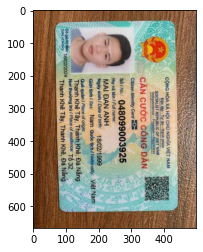

In [14]:
plt.imshow(image)

#### Corners on many images and saving


image 1/1 C:\Users\Admin\Desktop\A.N lab\test_imgs-raw\cccd.jpg: 384x640 1 botleft, 1 botright, 1 topleft, 230.9ms
Speed: 0.0ms preprocess, 230.9ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


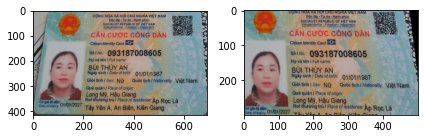

In [23]:
from ultralytics import YOLO

# Load a model
model = YOLO('C:/Users/Admin/Desktop/A.N lab/KIE/weights/YOLOv8n_4corners_v1.pt')  # pretrained YOLOv8n model
category_index = model.model.names

#### One image predicting with YOLO
def get_coordinate_dict(image, detection_boxes, detection_classes, category_index):
    """
    Args: image
    Return: transformed img by
    - Perspective transforming from 4 corners
    - Crop (in progress)
    """
    
    # eliminate outliners (if exist)
    coordinate_dict = dict()
    height, width, _ = image.shape

    for i in range(len(detection_classes)):
        label = str(category_index[detection_classes[i]])
        real_xmin = int(max(1, detection_boxes[i][0]))
        real_ymin = int(max(1, detection_boxes[i][1]))
        real_xmax = int(min(width, detection_boxes[i][2]))
        real_ymax = int(min(height, detection_boxes[i][3]))
        coordinate_dict[label] = (real_xmin, real_ymin, real_xmax, real_ymax)

    coordinate_dict = {
    key.replace('topleft', 'top_left').replace('topright', 'top_right').replace('botleft', 'bottom_left').replace('botright', 'bottom_right'): value for key, value in coordinate_dict.items()}

    return coordinate_dict

def corners_detect_transform(img_path):
    img = read_img_as_array(img_path)
    results = model.predict(source=img_path, conf=0.5)
    detection_boxes = np.array(results[0].boxes.xyxy)
    detection_classes = np.array(results[0].boxes.cls)

    coordinate_dict = get_coordinate_dict(image, detection_boxes, detection_classes, category_index)
    
    ## Alignment transformation
    cropped_img, done = align_image(img, coordinate_dict)

    return cropped_img, done

img_path = 'C:/Users/Admin/Desktop/A.N lab/test_imgs-raw/cccd.jpg'

image = read_img_as_array(img_path)
## Alignment transformation based on 4 corners
cropped_img, done = corners_detect_transform(img_path)

#### VISUALIZATION: Original vs cropped plot
# Create a figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2)  # 1 row, 2 columns

# Display images in subplots
ax1.imshow(image)
ax2.imshow(cropped_img)

# Adjust layout (optional)
plt.tight_layout()

# Show the plot
plt.show()

In [5]:
import os
from mpl_toolkits.axes_grid1 import ImageGrid

imgs_path = 'C:/Users/Admin/Desktop/A.N lab/dataset/raw id card/raw_pure_jpgs'

paths = os.listdir(imgs_path)

# Create an empty list to store image arrays
img_arr = []
total = 0
fail = 0

for idx, path in enumerate(paths):
    img_dir = f'{imgs_path}/{path}'
    total += 1
    # # Check if the image has 4 channels (RGBA)
    # if len(img.shape) > 2 and img.shape[2] == 4:
    #     # Convert RGBA to RGB
    #     img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)

    # 4 corners detection
    try:
        cropped, done = corners_detect_transform(img_dir)
    except:
        print('Can\'t crop/align this image')
        fail += 1
        continue

    # Save the image to a specific folder
    saving = Image.fromarray(cropped)
    img_sav_dir = 'C:/Users/Admin/Desktop/A.N lab/text detection/after_alignment_v4'
    saving.save(f'{img_sav_dir}/img{idx}.jpg')    

    img_arr.append(cropped)


# Define the grid layout
rows, cols = int(len(img_arr)), 1

fig = plt.figure(figsize=(32 * rows, 32 * cols))
grid = ImageGrid(fig, 111, nrows_ncols=(rows, cols), axes_pad=0.1)

# Display images in the grid
for ax, im in zip(grid, img_arr):
    ax.imshow(im)

# Adjust layout (optional)
# plt.tight_layout()

# Show the plot
plt.show()

image 1/1 C:\Users\Admin\Desktop\A.N lab\dataset\raw id card\raw_pure_jpgs\00cddf83-c1eb-4fc3-a1ed-68c2d6cae965_jpg.rf.ff46a67c45a65f95ebc166ae708e9ea6.jpg: 416x640 1 botleft, 1 botright, 1 topleft, 1 topright, 291.1ms
Speed: 1.0ms preprocess, 291.1ms inference, 14.0ms postprocess per image at shape (1, 3, 416, 640)

image 1/1 C:\Users\Admin\Desktop\A.N lab\dataset\raw id card\raw_pure_jpgs\00d69798-aad3-4005-8941-b12e539c99e8_jpg.rf.734cb0cc2dab5c78fb78459f85d9a6cc.jpg: 448x640 1 botright, 1 topleft, 300.1ms
Speed: 6.3ms preprocess, 300.1ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)
Image may be right angle! or Please try again

image 1/1 C:\Users\Admin\Desktop\A.N lab\dataset\raw id card\raw_pure_jpgs\00e884f6-ebc30306-c6be-4bd8-98cb-3a8c6065549f_jpg.rf.b25ef03f7453f38247e863855f5d6376.jpg: 640x480 1 botleft, 1 botright, 1 topleft, 1 topright, 264.7ms
Speed: 3.5ms preprocess, 264.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 C:\

In [ ]:
print(
    f'Applying alignment transform for {total} imgs',
    f'Success: {total - fail} imgs',
    f'Fail: {fail} imgs',
)

# Text detection
- args:
    - aligned img
- return 
    - text detected boxes: id boxes, name boxes and birth boxes

(640, 640, 3)

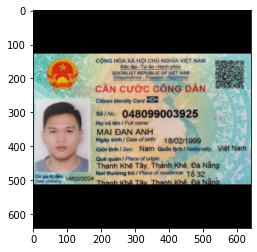

In [2]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

def read_img_as_array(img_path):
    image = Image.open(img_path)
    return np.asarray(image)

def resize_fit_black_edge(image, target_size=(640, 640)):
    # Get the original image dimensions
    original_height, original_width, _ = image.shape

    # Calculate the scaling factors for width and height
    width_scale = target_size[0] / original_width
    height_scale = target_size[1] / original_height

    # Determine the scaling factor to fit the image within the target size
    scale_factor = min(width_scale, height_scale)

    # Resize the image while maintaining the aspect ratio
    resized_image = cv2.resize(image, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_AREA)

    # Create a black canvas of the target size
    canvas = np.zeros((target_size[1], target_size[0], 3), dtype=np.uint8)

    # Calculate the position to paste the resized image
    x_offset = (target_size[0] - resized_image.shape[1]) // 2
    y_offset = (target_size[1] - resized_image.shape[0]) // 2

    # Paste the resized image onto the canvas
    canvas[y_offset:y_offset + resized_image.shape[0], x_offset:x_offset + resized_image.shape[1]] = resized_image

    return canvas

cropped_img = read_img_as_array('C:/Users/Admin/Desktop/A.N lab/test_imgs-after_alighment/img1.jpg')

# model input size (640, 640)
# so preprocess image by resize_fit_black_edge (without distortion)
cropped_img = resize_fit_black_edge(cropped_img)

plt.imshow(cropped_img)
cropped_img.shape

## Roboflow API

In [4]:
from roboflow import Roboflow
import supervision as sv
import cv2

rf = Roboflow(api_key="JSVeJAx7mmzoT48naM0W")
project = rf.workspace().project("text-detection-from-id-card")
model = project.version(3).model

# Object detection output: https://docs.roboflow.com/deploy/hosted-api/custom-models/object-detection
# cropped_img_path = 'C:/Users/Admin/Desktop/A.N lab/test_imgs-after_alighment/image1.jpg'
result = model.predict(cropped_img, confidence=50, overlap=50).json()

loading Roboflow workspace...
loading Roboflow project...


In [ ]:
image = np.copy(cropped_img)

labels = [item["class"] for item in result["predictions"]]
detections = sv.Detections.from_inference(result)

label_annotator = sv.LabelAnnotator()
box_annotator = sv.BoxAnnotator()

annotated_image = box_annotator.annotate(
    scene=image, detections=detections)
annotated_image = label_annotator.annotate(
    scene=annotated_image, detections=detections, labels=labels)

sv.plot_image(image=annotated_image, size=(16, 16))

### Ouput from Roboflow as righ format
- Get detection boxes, detection classes from Roboflow result
- Apply NMS
- Return boxes, classes.astype('int), category_index

In [ ]:
sv.Detections.from_inference(result)

In [11]:
## Get detection boxes, detection classes from Roboflow result
def get_corners(result):
    detection_boxes = []
    detection_classes = []
    category_index = {}

    for prediction in result['predictions']:
        x_center = prediction['x']
        y_center = prediction['y']
        width = prediction['width']
        height = prediction['height']
        class_id = prediction['class_id'] + 1
        class_name = prediction['class']

        x1 = x_center - (width/2)
        y1 = y_center - (height/2)
        x2 = x_center + (width/2)
        y2 = y_center + (height/2)

        # Convert the bounding box coordinates to the format [y01, x01, y02, x02]
        # detection_boxes.append([y, x, y + height, x + width])
        detection_boxes.append([y1, x1, y2, x2])
        detection_classes.append(class_id)
        category_index[class_id] = {'id': class_id, 'name': class_name}

    detection_boxes = np.array(detection_boxes) # casting as array
    detection_classes = np.array(detection_classes).astype('float') # float converting
    
    return detection_boxes, detection_classes, category_index

detection_boxes, detection_classes, category_index = get_corners(result)
print(f'Raw Detection boxed: \n {detection_boxes},'
        f'\n Detection classes: \n {detection_classes}'
        f'\n Category index: \n {category_index}'
    )

## Apply NMS
def non_max_suppression_fast(boxes, labels, overlapThresh):
    """ filters object detector predictions / removes duplicates

    Args:
        boxes: 
        labels:
        overlap threshold: 
    Returns:
        the bounding boxes that were picked using the integer data type
    """
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return [None, None]

    # if the bounding boxes are integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
    #
    # initialize the list of picked indexes
    pick = []
    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 1]
    y1 = boxes[:, 0]
    x2 = boxes[:, 3]
    y2 = boxes[:, 2]

    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlapThresh)[0])))

    # return only the bounding boxes that were picked using the
    # integer data type
    final_labels = [labels[idx] for idx in pick]
    final_boxes = boxes[pick].astype("int")
    return final_boxes, final_labels

detection_boxes, detection_classes = non_max_suppression_fast(boxes=detection_boxes,
                                                                        labels=detection_classes,
                                                                        overlapThresh=0.15)
## Return boxes, classes.astype('int), category_index
detection_classes = np.array(detection_classes).astype("int")

Raw Detection boxed: 
 [[177. 285. 195. 327.]
 [177. 200. 195. 235.]
 [177. 240. 195. 281.]
 [197. 347. 215. 433.]
 [133. 251. 162. 425.]],
 Detection classes: 
 [3. 3. 3. 1. 2.]
 Category index: 
 {3: {'id': 3, 'name': 'name'}, 1: {'id': 1, 'name': 'birthday'}, 2: {'id': 2, 'name': 'id'}}


In [12]:
category_index

{3: {'id': 3, 'name': 'name'},
 1: {'id': 1, 'name': 'birthday'},
 2: {'id': 2, 'name': 'id'}}

## YOLOv8 text detection

#### Load YOLOv8, basic output
'''- Get text detected result from YOLOv8 and basic preprocessing
    - Get detection boxes, detection classes from YOLOv8 result
    - Preprocessing with Apply NMS'''

    - Args: model, aligned_img_path
    - Return: id_boxes, name_boxes and birth_boxes

In [29]:
from ultralytics import YOLO

# Load a text detector model
text_detection_model = YOLO('C:/Users/Admin/Desktop/A.N lab/KIE/weights/YOLOv8-text_detection-v3.pt')  # pretrained YOLOv8n model
text_detection_model.model.names

{0: 'birthday', 1: 'id', 2: 'name'}

### Text detecting helper func

In [4]:
## Encapsulate output of text detector in dictionary
def _get_text_coordinate_dict(image, detection_boxes, detection_classes, category_index):
    """
    Args: image, detection_boxes, detection_classes, category_index
    Return: Dictionary
    - detected label: boxes
    ...
    - category_index: category_index
    """
    # eliminate outliers (if exist)
    coordinate_dict = dict()
    for label in category_index.values():
        coordinate_dict[label] = []
    height, width, _ = image.shape

    for idx, i in enumerate(detection_classes):
        label = category_index[i]
        real_xmin = int(max(1, detection_boxes[idx][0]))
        real_ymin = int(max(1, detection_boxes[idx][1]))
        real_xmax = int(min(width, detection_boxes[idx][2]))
        real_ymax = int(min(height, detection_boxes[idx][3]))

        coordinate_dict[label].append((real_xmin, real_ymin, real_xmax, real_ymax))

    coordinate_dict = {
        key.replace('topleft', 'top_left').replace('topright', 'top_right').replace('botleft', 'bottom_left').replace('botright', 'bottom_right'): value for key, value in coordinate_dict.items()
    }

    coordinate_dict['category_index'] = category_index

    return coordinate_dict

def _text_detection_inference(model, img_path):
    results = model.predict(source=img_path, conf=0.5)
    detection_boxes = np.array(results[0].boxes.xyxy)
    detection_classes = np.array(results[0].boxes.cls)

    return detection_boxes, detection_classes

# ## Sanity check
# img_path = 'C:/Users/Admin/Desktop/A.N lab/test_imgs-after_alighment/img2.jpg'
# img = read_img_as_array(img_path)
# # Output of text detector
# detection_boxes, detection_classes = _text_detection_inference(model, img_path)
# category_index = model.model.names

# # preprocessing output -> encapsulate into a dictionary
# _get_text_coordinate_dict(img, detection_boxes, detection_classes, category_index)

### Draw text detected bounding boxes


image 1/1 C:\Users\Admin\Desktop\A.N lab\test_imgs-after_alighment\img1.jpg: 384x640 1 birthday, 1 id, 3 names, 262.1ms
Speed: 2.9ms preprocess, 262.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


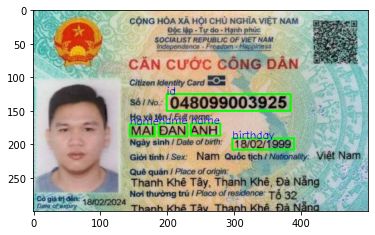

In [20]:
def draw_text_detected(img_path, model):
    ''' Draw 4 corners output by Corner detector
    Args: 
        - Model: instance of Corner detector
        - 
    Return:
        - Annotated img
    
    '''
    img = read_img_as_array(img_path)

    # Output of text detector
    detection_boxes, detection_classes = _text_detection_inference(model, img_path)
    category_index = model.model.names
    
    # preprocessing output -> encapsulate into a dictionary
    coordinate_dict = _get_text_coordinate_dict(img, detection_boxes, detection_classes, category_index)
    del coordinate_dict['category_index']
    cr_img = np.copy(img)
    for name, boxes in coordinate_dict.items():
        for box in boxes:
            start_point = (box[0], box[1])
            end_point = (box[2], box[3])
            color = (0, 255, 0)
            # Draw bounding box
            img = cv2.rectangle(cr_img, start_point, end_point, color, 2) 

            # Draw label
            label = str(name)
            cv2.putText(cr_img, label, (start_point[0], start_point[1]), cv2.FONT_HERSHEY_SIMPLEX, color=(0, 0, 255),
                fontScale=0.5)
        
    return cr_img

img_path = 'C:/Users/Admin/Desktop/A.N lab/test_imgs-after_alighment/img1.jpg'
# Draw bounding boxes of Corner detector
text_detected_img = draw_text_detected(img_path, model)
plt.imshow(text_detected_img)

### Preprocessing with NMS

In [5]:
"""NMS (Non maximum suppression)
- preprocessing boxes: eliminate redundant boxes (in some cases)"""

## Apply NMS
def non_max_suppression_fast(boxes, labels, overlapThresh):
    """ filters object detector predictions / removes duplicates

    Args:
        boxes: 
        labels:
        overlap threshold: 
    Returns:
        the bounding boxes that were picked using the integer data type
    """
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return [None, None]

    # if the bounding boxes are integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
    #
    # initialize the list of picked indexes
    pick = []
    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 1]
    y1 = boxes[:, 0]
    x2 = boxes[:, 3]
    y2 = boxes[:, 2]

    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlapThresh)[0])))

    # return only the bounding boxes that were picked using the
    # integer data type
    final_labels = [labels[idx] for idx in pick]
    final_labels = np.array(final_labels).astype("int")

    final_boxes = boxes[pick].astype("int")
    return final_boxes, final_labels

img_path = 'C:/Users/Admin/Desktop/A.N lab/test_imgs-after_alighment/img2.jpg'

detection_boxes, detection_classes = _text_detection_inference(model, img_path)
detection_boxes, detection_classes = non_max_suppression_fast(boxes=detection_boxes,
                                                                        labels=detection_classes,
                                                                        overlapThresh=0.15)


img_path = 'C:/Users/Admin/Desktop/A.N lab/test_imgs-after_alighment/img2.jpg'
detection_boxes, detection_classes


image 1/1 C:\Users\Admin\Desktop\A.N lab\test_imgs-after_alighment\img2.jpg: 384x640 1 birthday, 1 id, 3 names, 299.0ms
Speed: 176.8ms preprocess, 299.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


(array([[325, 190, 420, 207],
        [218, 119, 415, 147],
        [268, 166, 317, 186],
        [201, 168, 265, 188],
        [160, 165, 195, 186]]),
 array([0, 1, 2, 2, 2]))

### Sort text helper function
- Args: detection_boxes, detection_classes
- Return: id_boxes, name_boxes and birth_boxes

In [6]:
print(f'Catefory index {model.model.names}')

def get_y1(x):
    return x[1]


def get_x1(x):
    return x[0]


def sort_each_category(category_text_boxes):
    """
    Args: boxes
    Return:
    - Right order boxes corresponding to indexes: top to bottom, left to right 
    """
    try:
        min_y1 = min(category_text_boxes, key=get_y1)[0]
    except:
        return None

    mask = np.where(category_text_boxes[:, 0] < min_y1 + 10, True, False)
    line1_text_boxes = category_text_boxes[mask]
    line2_text_boxes = category_text_boxes[np.invert(mask)]

    line1_text_boxes = sorted(line1_text_boxes, key=get_x1)
    line2_text_boxes = sorted(line2_text_boxes, key=get_x1)

    if len(line2_text_boxes) != 0:
        merged_text_boxes = [*line1_text_boxes, *line2_text_boxes]
    else:
        merged_text_boxes = line1_text_boxes

    return merged_text_boxes

def sort_text(detection_boxes, detection_labels):
    """Sort box in name_boxes as right order, i.e vu quy ngox > vu ngoc quy (as reader 
    view/order from top to bottom, left to right)

    Args:
    - detection boxes
    - detection labels
    Return:
    - arranged id_boxes, name_boxes, birth_boxes according to its coordinate

    """
    
    #  Get boxes correspond to its label 
    detection_labels = np.array(detection_labels)
    birth_boxes = detection_boxes[detection_labels == 0]
    id_boxes = detection_boxes[detection_labels == 1]
    name_boxes = detection_boxes[detection_labels == 2]

    # arrange boxes
    id_boxes = sort_each_category(id_boxes)
    name_boxes = sort_each_category(name_boxes)
    birth_boxes = sort_each_category(birth_boxes)

    return id_boxes, name_boxes, birth_boxes

# sort text boxes according to coordinate
id_boxes, name_boxes, birth_boxes = sort_text(detection_boxes, detection_classes)
print(
    f'After sorting function:'
    f'\n id \n {id_boxes}',
    f'\n name \n {name_boxes}',
    f'\n birth \n {birth_boxes}',
)

Catefory index {0: 'birthday', 1: 'id', 2: 'name'}
After sorting function:
 id 
 [array([218, 119, 415, 147])] 
 name 
 [array([160, 165, 195, 186]), array([201, 168, 265, 188]), array([268, 166, 317, 186])] 
 birth 
 [array([325, 190, 420, 207])]


#### VISUALIZATION: Alignment vs text detected img (optional)

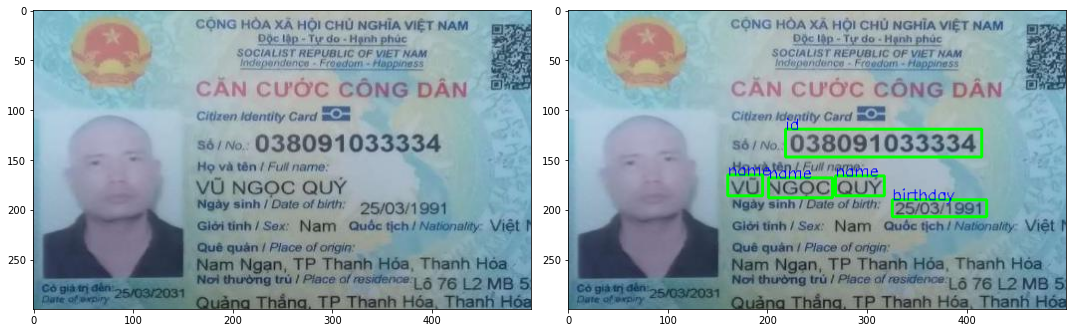

In [24]:
#### VISUALIZATION: Cropped vs text detected img

cropped_img = read_img_as_array('C:/Users/Admin/Desktop/A.N lab/test_imgs-after_alighment/img2.jpg')

# Create a figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))  # 1 row, 3 columns
# Display images in subplots
ax1.imshow(cropped_img)
ax2.imshow(text_detected_img)

# Adjust layout (optional)
plt.tight_layout()

# Show the plot
plt.show()

#### Get all text detected (id, name, birthday) patch imgs

In [44]:
# helper func
def _text_crop(cropped_img, boxes):
    '''
    cropped_img: (h, w, c)
    '''
    text_crop = []
    if len(boxes) == 1:
        x_min, y_min, x_max, y_max = boxes[0]
        text_crop.append(cropped_img[y_min:y_max, x_min:x_max])
    else:
        for box in boxes:
            x_min, y_min, x_max, y_max = box
            text_crop.append(cropped_img[y_min:y_max, x_min:x_max])

    return text_crop

# MULTI recognition
def multi_text_crop(img_path, text_detection_model):
    
    # Output from text detection
    detection_boxes, detection_classes = _text_detection_inference(text_detection_model, img_path)
    ## NMS applying
    detection_boxes, detection_classes = non_max_suppression_fast(boxes=detection_boxes,
                                                                            labels=detection_classes,
                                                                            overlapThresh=0.15)

    # Sort text as correct order
    id_boxes, name_boxes, birth_boxes = sort_text(detection_boxes, detection_classes)

    # crop required boxes
    cropped_img = read_img_as_array(img_path)
    list_text_crop = list()
    list_text_crop.extend(_text_crop(cropped_img, id_boxes)) # add name text imgs
    list_text_crop.extend(_text_crop(cropped_img, name_boxes)) # add name text imgs
    list_text_crop.extend(_text_crop(cropped_img, birth_boxes)) # add name text imgs

    # list_text_crop = [list_text_crop.append(entry) for entry in text_preds]
    # id_text_crops = _text_crop(cropped_img, id_boxes)
    # birth_text_crops = _text_crop(cropped_img, name_boxes)
    return list_text_crop

list_text_crop = multi_text_crop(img_path, text_detection_model)
for idx, img in enumerate(list_text_crop):
    saving = Image.fromarray(img)
    img_sav_dir = 'C:/Users/Admin/Desktop/A.N lab/test_imgs-text-regconition'
    saving.save(f'{img_sav_dir}/img{idx}.jpg')


image 1/1 C:\Users\Admin\Desktop\A.N lab\test_imgs-after_alighment\img2.jpg: 384x640 1 birthday, 1 id, 3 names, 462.5ms
Speed: 0.0ms preprocess, 462.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


In [49]:
import os
from mpl_toolkits.axes_grid1 import ImageGrid

# src and destination path
src_imgs_path = 'C:/Users/Admin/Desktop/A.N lab/p2-text detection/v5 right for annotation'
sav_img_dir = 'C:/Users/Admin/Desktop/A.N lab/p3-text_regconition/text_patches-v1'

paths = os.listdir(src_imgs_path)

# Create an empty list to store image arrays
img_arr = []
total = 0
fail = 0

for idx, path in enumerate(paths):
    src_img_dir = f'{src_imgs_path}/{path}'
    total += 1
    # # Check if the image has 4 channels (RGBA)
    # if len(img.shape) > 2 and img.shape[2] == 4:
    #     # Convert RGBA to RGB
    #     img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)

    # text detection > return text crops
    try:
        list_text_crop = multi_text_crop(src_img_dir, text_detection_model)
    except:
        print(f'Can\'t detect text {path}')
        fail += 1
        continue

    # SAVING
    for idx, img in enumerate(list_text_crop):
        saving = Image.fromarray(img)
        saving.save(f'{sav_img_dir}/{path}_{idx}.jpg')

print(
    f'\n Success: {total - fail} imgs',
    f'\n Fail: {fail} imgs',
)

image 1/1 C:\Users\Admin\Desktop\A.N lab\p2-text detection\v5 right for annotation\img101.jpg: 384x640 1 birthday, 1 id, 3 names, 415.1ms
Speed: 2.0ms preprocess, 415.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\Admin\Desktop\A.N lab\p2-text detection\v5 right for annotation\img102.jpg: 384x640 1 birthday, 1 id, 3 names, 396.4ms
Speed: 0.0ms preprocess, 396.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\Admin\Desktop\A.N lab\p2-text detection\v5 right for annotation\img103.jpg: 384x640 1 birthday, 1 id, 4 names, 372.1ms
Speed: 3.7ms preprocess, 372.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\Admin\Desktop\A.N lab\p2-text detection\v5 right for annotation\img104.jpg: 384x640 1 birthday, 1 id, 3 names, 397.8ms
Speed: 0.0ms preprocess, 397.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\Admin\Desktop\A.N lab\p2-text det

# Text regconition
- args:
    - aligned image
    - id detected boxes
    - name detected boxes
    - birth detected boxes
- return 
    - required extracted information

## Load VietOCR

In [50]:
import math

import torch
from torch import nn
from torchvision import models
from collections import defaultdict


### CNN (VGG)
class Vgg(nn.Module):
    def __init__(self, name, ss, ks, hidden, pretrained=True, dropout=0.5):
        super(Vgg, self).__init__()
        cnn = models.vgg19_bn(pretrained=pretrained)

        pool_idx = 0
        
        for i, layer in enumerate(cnn.features):
            if isinstance(layer, torch.nn.MaxPool2d):        
                cnn.features[i] = torch.nn.AvgPool2d(kernel_size=ks[pool_idx], stride=ss[pool_idx], padding=0)
                pool_idx += 1
 
        self.features = cnn.features
        self.dropout = nn.Dropout(dropout)
        self.last_conv_1x1 = nn.Conv2d(512, hidden, 1)

    def forward(self, x):
        """
        Shape: 
            - x: (N, C, H, W)
            - output: (W, N, C)
        """

        conv = self.features(x)
        conv = self.dropout(conv)
        conv = self.last_conv_1x1(conv)

        conv = conv.transpose(-1, -2)
        conv = conv.flatten(2)
        conv = conv.permute(-1, 0, 1)
        return conv


def vgg19_bn(ss, ks, hidden, pretrained=True, dropout=0.5):
    return Vgg('vgg19_bn', ss, ks, hidden, pretrained, dropout)

class CNN(nn.Module):
    def __init__(self, backbone, **kwargs):
        super(CNN, self).__init__()
        self.model = vgg19_bn(**kwargs)

    def forward(self, x):
        return self.model(x)

    def freeze(self):
        for name, param in self.model.features.named_parameters():
            if name != 'last_conv_1x1':
                param.requires_grad = False

    def unfreeze(self):
        for param in self.model.features.parameters():
            param.requires_grad = True


### LANGUAGE TRANSFORMER
class LanguageTransformer(nn.Module):
    def __init__(self, vocab_size, 
                    d_model, nhead, 
                    num_encoder_layers, num_decoder_layers, 
                    dim_feedforward, max_seq_length, 
                    pos_dropout, trans_dropout):
        super().__init__()
        
        self.d_model = d_model
        self.embed_tgt = nn.Embedding(vocab_size, d_model)
        self.pos_enc = PositionalEncoding(d_model, pos_dropout, max_seq_length)

        self.transformer = nn.Transformer(d_model, nhead, 
                                            num_encoder_layers, num_decoder_layers, 
                                            dim_feedforward, trans_dropout)
        
        self.fc = nn.Linear(d_model, vocab_size)
        
    def forward(self, src, tgt, src_key_padding_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        """
        Shape:
            - src: (W, N, C)
            - tgt: (T, N) 
            - src_key_padding_mask: (N, S)
            - tgt_key_padding_mask: (N, T)
            - memory_key_padding_mask: (N, S)
            - output: (N, T, E)
            
        """
        tgt_mask = self.gen_nopeek_mask(tgt.shape[0]).to(src.device)
        
        src = self.pos_enc(src*math.sqrt(self.d_model))

        tgt = self.pos_enc(self.embed_tgt(tgt) * math.sqrt(self.d_model))
        
        output = self.transformer(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask=src_key_padding_mask,
                                    tgt_key_padding_mask=tgt_key_padding_mask, memory_key_padding_mask=memory_key_padding_mask)
        output = output.transpose(0, 1)
        return self.fc(output)

    def gen_nopeek_mask(self, length):
        mask = (torch.triu(torch.ones(length, length)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))

        return mask
    
    def forward_encoder(self, src):
        src = self.pos_enc(src*math.sqrt(self.d_model))
        memory = self.transformer.encoder(src)
        return memory
    
    def forward_decoder(self, tgt, memory):
        tgt_mask = self.gen_nopeek_mask(tgt.shape[0]).to(tgt.device)
        tgt = self.pos_enc(self.embed_tgt(tgt) * math.sqrt(self.d_model))
        
        output = self.transformer.decoder(tgt, memory, tgt_mask=tgt_mask)
        output = output.transpose(0, 1)

        return self.fc(output), memory
    
    def expand_memory(self, memory, beam_size):
        memory = memory.repeat(1, beam_size, 1)
        return memory
    
    def get_memory(self, memory, i):
        memory = memory[:, [i], :]
        return memory

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=100):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]

        return self.dropout(x)

class LearnedPositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=100):
        super(LearnedPositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        self.pos_embed = nn.Embedding(max_len, d_model)
        self.layernorm = LayerNorm(d_model)

    def forward(self, x):
        seq_len = x.size(0)
        pos = torch.arange(seq_len, dtype=torch.long, device=x.device)
        pos = pos.unsqueeze(-1).expand(x.size()[:2])
        x = x + self.pos_embed(pos)
        return self.dropout(self.layernorm(x))

class LayerNorm(nn.Module):
    "A layernorm module in the TF style (epsilon inside the square root)."
    def __init__(self, d_model, variance_epsilon=1e-12):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(d_model))
        self.beta  = nn.Parameter(torch.zeros(d_model))
        self.variance_epsilon = variance_epsilon

    def forward(self, x):
        u = x.mean(-1, keepdim=True)
        s = (x - u).pow(2).mean(-1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.variance_epsilon)
        return self.gamma * x + self.beta  
    

### VIET-OCR
class VietOCR(nn.Module):
    def __init__(self, vocab_size,
                    backbone,
                    cnn_args, 
                    transformer_args, seq_modeling='transformer'):
        
        super(VietOCR, self).__init__()
        
        self.cnn = CNN(backbone, **cnn_args)
        self.transformer = LanguageTransformer(vocab_size, **transformer_args)

    def forward(self, img, tgt_input, tgt_key_padding_mask):
        """
        Shape:
            - img: (N, C, H, W)
            - tgt_input: (T, N)
            - tgt_key_padding_mask: (N, T)
            - output: b t v
        """
        src = self.cnn(img)
        outputs = self.transformer(src, tgt_input, tgt_key_padding_mask=tgt_key_padding_mask)
        return outputs


#### Vocal

class Vocab():
    def __init__(self, chars):
        self.pad = 0
        self.go = 1
        self.eos = 2
        self.mask_token = 3

        self.chars = chars

        self.c2i = {c:i+4 for i, c in enumerate(chars)}

        self.i2c = {i+4:c for i, c in enumerate(chars)}
        
        self.i2c[0] = '<pad>'
        self.i2c[1] = '<sos>'
        self.i2c[2] = '<eos>'
        self.i2c[3] = '*'

    def encode(self, chars):
        return [self.go] + [self.c2i[c] for c in chars] + [self.eos]
    
    def decode(self, ids):
        first = 1 if self.go in ids else 0
        last = ids.index(self.eos) if self.eos in ids else None
        sent = ''.join([self.i2c[i] for i in ids[first:last]])
        return sent
    
    def __len__(self):
        return len(self.c2i) + 4
    
    def batch_decode(self, arr):
        texts = [self.decode(ids) for ids in arr]
        return texts

    def __str__(self):
        return self.chars

#### Translate and build model function

def translate(img, model, max_seq_length=128, sos_token=1, eos_token=2):
    """data: BxCXHxW"""
    model.eval()
    device = img.device

    with torch.no_grad():
        src = model.cnn(img)
        memory = model.transformer.forward_encoder(src)

        translated_sentence = [[sos_token] * len(img)]
        max_length = 0

        while max_length <= max_seq_length and not all(np.any(np.asarray(translated_sentence).T == eos_token, axis=1)):
            tgt_inp = torch.LongTensor(translated_sentence).to(device)
            output, memory = model.transformer.forward_decoder(tgt_inp, memory)
            output = output.to('cpu')

            _, indices = torch.topk(output, 5)

            indices = indices[:, -1, 0]
            indices = indices.tolist()

            translated_sentence.append(indices)
            max_length += 1

            del output

        translated_sentence = np.asarray(translated_sentence).T

    return translated_sentence


def build_model(config):
    vocab = Vocab(config['vocab'])
    device = config['device']
    
    model = VietOCR(len(vocab),
            config['backbone'],
            config['cnn'], 
            config['transformer'],
            config['seq_modeling'])
    
    model = model.to(device)

    return model, vocab

### Predictor class
class Predictor(object):
    def __init__(self, config):
        device = config['device']

        model, vocab = build_model(config)
        weights = config['weights']

        model.load_state_dict(torch.load(weights, map_location=torch.device(device)))

        self.config = config
        self.model = model
        self.vocab = vocab

    def predict(self, img):
        img = self.preprocess_input(img)
        img = np.expand_dims(img, axis=0)
        img = torch.FloatTensor(img)
        img = img.to(self.config['device'])
        s = translate(img, self.model)[0].tolist()

        s = self.vocab.decode(s)

        return s

    def batch_predict(self, images):
        """
        param: images : list of ndarray
        """
        batch_dict, indices = self.batch_process(images)
        list_keys = [i for i in batch_dict if batch_dict[i] != batch_dict.default_factory()]
        result = list([])

        for width in list_keys:
            batch = batch_dict[width]
            batch = np.asarray(batch)
            batch = torch.FloatTensor(batch)
            batch = batch.to(self.config['device'])
            sent = translate(batch, self.model).tolist()

            batch_text = self.vocab.batch_decode(sent)
            result.extend(batch_text)

        # sort text result to original coordinate
        z = zip(result, indices)
        sorted_result = sorted(z, key=lambda element: element[1])
        result, _ = zip(*sorted_result)

        return result

    def preprocess_input(self, image):
        """
        param: image: ndarray of image
        """
        h, w, _ = image.shape
        new_w, image_height = self.resize_v1(w, h, self.config['dataset']['image_height'],
                                                self.config['dataset']['image_min_width'],
                                                self.config['dataset']['image_max_width'])

        img = cv2.resize(image, (new_w, image_height))
        img = np.transpose(img, (2, 0, 1))
        img = img / 255.0

        return img

    def batch_process(self, images):
        batch_img_dict = defaultdict(list)
        image_height = self.config['dataset']['image_height']

        batch_img_li = [self.preprocess_input(img) for img in images]
        batch_imgs, width_list, indices = self.sort_width(batch_img_li, reverse=False)

        min_bucket_width = min(width_list)
        max_width = max(width_list)
        thresh = 30
        max_bucket_width = np.minimum(min_bucket_width + thresh, max_width)

        for i, image in enumerate(batch_imgs):
            w = image.shape[2]

            # reset min_bucket_width, max_bucket_width
            if w > max_bucket_width:
                min_bucket_width = w
                max_bucket_width = np.minimum(min_bucket_width + thresh, max_width)

            avg_bucket_width = int((max_bucket_width + min_bucket_width) / 2)

            new_img = self.resize_v2(image, avg_bucket_width, height=image_height)
            batch_img_dict[avg_bucket_width].append(new_img)

        return batch_img_dict, indices

    @staticmethod
    def sort_width(batch_img, reverse=False):
        def get_img_width(element):
            img = element[0]
            c, h, w = img.shape
            return w

        batch = list(zip(batch_img, range(len(batch_img))))
        sorted_batch = sorted(batch, key=get_img_width, reverse=reverse)
        sorted_batch_img, indices = list(zip(*sorted_batch))

        return sorted_batch_img, list(map(get_img_width, batch)), indices

    @staticmethod
    def resize_v1(w, h, expected_height, image_min_width, image_max_width):
        new_w = int(expected_height * float(w) / float(h))
        round_to = 10
        new_w = math.ceil(new_w / round_to) * round_to
        new_w = max(new_w, image_min_width)
        new_w = min(new_w, image_max_width)

        return new_w, expected_height

    @staticmethod
    def resize_v2(img, width, height):
        new_img = np.transpose(img, (1, 2, 0))
        new_img = cv2.resize(new_img, (width, height), cv2.INTER_AREA)
        new_img = np.transpose(new_img, (2, 0, 1))

        return new_img




In [51]:
import yaml

text_recognition = {
    'base_config': 'C:/Users/Admin/Desktop/A.N lab/KIE/weights/REF_weights-CMND OCR/base.yml',
    'vgg_config': 'C:/Users/Admin/Desktop/A.N lab/KIE/weights/REF_weights-CMND OCR/vgg-transformer.yml',
    'model_weight': 'C:/Users/Admin/Desktop/A.N lab/KIE/weights/REF_weights-CMND OCR/transformerocr.pth'
}


class TextRecognition(object):
    def __init__(self):
        self.ocr_config = self.load_config()
        self.detector = Predictor(self.ocr_config)

    def load_config(self):
        # load base config
        ocr_config = self.read_from_config(file_yml=text_recognition['base_config'])

        # load vgg transformer config
        vgg_config = self.read_from_config(file_yml=text_recognition['vgg_config'])

        # update base config
        ocr_config.update(vgg_config)

        # load model from checkpoint
        ocr_config['weights'] = text_recognition['model_weight']
        ocr_config['predictor']['beamsearch'] = False

        return ocr_config

    @staticmethod
    def read_from_config(file_yml):
        with open(file_yml, encoding='utf-8') as f:
            config = yaml.safe_load(f)

        return config

    def predict(self, image):
        # image = Image.fromarray(image)
        result = self.detector.predict(image)

        return result

    def predict_on_batch(self, batch_images):
        return self.detector.batch_predict(batch_images)


text_recognition_model = TextRecognition()


## Regconition inference one img

In [9]:
print(
    f'After sorting function:'
    f'\n id \n {id_boxes}',
    f'\n name \n {name_boxes}',
    f'\n birth \n {birth_boxes}',
)
# plt.imshow(text_detected_img)

After sorting function:
 id 
 [array([218, 119, 415, 147])] 
 name 
 [array([160, 165, 195, 186]), array([201, 168, 265, 188]), array([268, 166, 317, 186])] 
 birth 
 [array([325, 190, 420, 207])]


### Crop patch img func

#### Recognize Name with VietOCR

Name: vũ ngọc quý


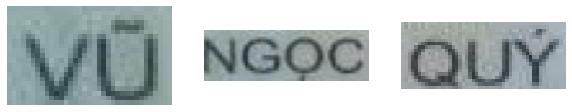

In [13]:
# crop boxes according to coordinate  preprocessing
def _text_crop(cropped_img, boxes):
    '''
    cropped_img: (h, w, c)
    '''
    text_crop = []
    if len(boxes) == 1:
        x_min, y_min, x_max, y_max = boxes[0]
        text_crop.append(cropped_img[y_min:y_max, x_min:x_max])
    else:
        for box in boxes:
            x_min, y_min, x_max, y_max = box
            text_crop.append(cropped_img[y_min:y_max, x_min:x_max])

    return text_crop

cropped_img = read_img_as_array('C:/Users/Admin/Desktop/A.N lab/test_imgs-after_alighment/img2.jpg')
name_text_crops = _text_crop(cropped_img, name_boxes)
name_texts = text_recognition_model.predict_on_batch(name_text_crops)
whole_name_text = ' '.join(name_texts[0:len(name_texts) + 1])
print(f'Name: {whole_name_text}')

fig = plt.figure(figsize=(10, 30))
n = len(name_text_crops)
for i in range(n):
    ax = fig.add_subplot(1, n, i+1)
    ax.imshow(name_text_crops[i])
    ax.axis('off')

plt.show()

### Recognize id, birthday with paddleOCR

In [14]:
from paddleocr import PaddleOCR

# need to run only once to download and load model into memory
numeric_text_recognizer = PaddleOCR(use_gpu=False)  

[2024/03/28 09:38:22] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\Admin/.paddleocr/whl\\det\\ch\\ch_PP-OCRv4_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\Admin/.paddleocr/whl\\rec\\ch\\ch_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_len

In [15]:
# numeric regconition
def _paddle_reg(model, cropped_img, boxes):
    text_crops = _text_crop(cropped_img, boxes) # get patch of id text
    result = model.ocr(text_crops[0]) # paddleOCR

    return result[0][0][1][0], result[0][0][1][1]

id_text, conf = _paddle_reg(numeric_text_recognizer, cropped_img, id_boxes)
birth_text, conf = _paddle_reg(numeric_text_recognizer, cropped_img, birth_boxes)
print(
    f'\n id: {id_text}'
    f'\n birth: {birth_text}'
)

[2024/03/28 09:38:39] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2024/03/28 09:38:39] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.06826162338256836
[2024/03/28 09:38:39] ppocr DEBUG: rec_res num  : 1, elapsed : 0.2889266014099121
[2024/03/28 09:38:39] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2024/03/28 09:38:39] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.17202138900756836
[2024/03/28 09:38:39] ppocr DEBUG: rec_res num  : 1, elapsed : 0.14315438270568848

 id: 038091033334
 birth: 25/03/1991


### Encapsulate in one func

[2024/03/28 09:39:04] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2024/03/28 09:39:04] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.018059253692626953
[2024/03/28 09:39:04] ppocr DEBUG: rec_res num  : 1, elapsed : 0.09972691535949707
[2024/03/28 09:39:04] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2024/03/28 09:39:04] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.0039441585540771484
[2024/03/28 09:39:04] ppocr DEBUG: rec_res num  : 1, elapsed : 0.03422355651855469
 
 Result: {'name': 'vũ ngọc quý', 'id': '038091033334', 'birth': '25/03/1991'}


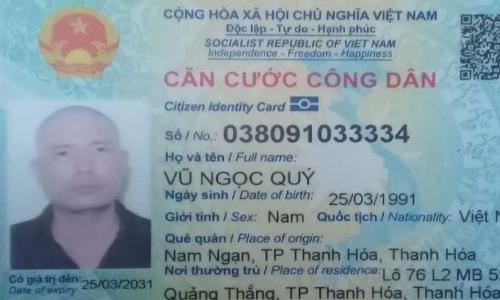

In [16]:
# numeric regconition
def _paddle_reg(model, cropped_img, boxes):
    text_crops = _text_crop(cropped_img, boxes) # get patch of id text
    result = model.ocr(text_crops[0]) # paddleOCR

    return result[0][0][1][0], result[0][0][1][1]

# crop boxes according to coordinate  preprocessing
def _text_crop(cropped_img, boxes):
    '''
    cropped_img: (h, w, c)
    '''
    text_crop = []
    if len(boxes) == 1:
        x_min, y_min, x_max, y_max = boxes[0]
        text_crop.append(cropped_img[y_min:y_max, x_min:x_max])
    else:
        for box in boxes:
            x_min, y_min, x_max, y_max = box
            text_crop.append(cropped_img[y_min:y_max, x_min:x_max])

    return text_crop

def text_regcornize(text_recognition_model, numeric_text_recognizer,
                    cropped_img, id_boxes, name_boxes, birth_boxes):
    result_dict = dict()

    # recognize name with VietOCR
    name_text_crops = _text_crop(cropped_img, name_boxes)
    name_texts = text_recognition_model.predict_on_batch(name_text_crops)
    whole_name_text = ' '.join(name_texts[0:len(name_texts) + 1])
    result_dict['name'] = whole_name_text

    # recognize id, birthday with paddleOCR
    id_text, _ = _paddle_reg(numeric_text_recognizer, cropped_img, id_boxes)
    birth_text, _ = _paddle_reg(numeric_text_recognizer, cropped_img, birth_boxes)
    result_dict['id'] = id_text
    result_dict['birth'] = birth_text

    return result_dict

result = text_regcornize(text_recognition_model, numeric_text_recognizer,
                        cropped_img, id_boxes, name_boxes, birth_boxes)

print(f' \n Result: {result}')
Image.fromarray(cropped_img)
# # Draw text detected boxes
# fig, axs = plt.subplots(len(name_text_crop), 1, figsize = (5, 15))
# for ax, text_crop in zip(axs, name_text_crop):
#     ax.imshow(text_crop)

# # Adjust layout (optional)
# plt.tight_layout()

# # Show the plot
# plt.show()

## Regconition inference many img (part 1 aggregate funcs)

In [17]:
import yaml
from ultralytics import YOLO
from paddleocr import PaddleOCR

# Load a text detector model
text_detection_model = YOLO('C:/Users/Admin/Desktop/A.N lab/KIE/weights/YOLOv8-text_detection-v3.pt')  # pretrained YOLOv8n model
print(text_detection_model.model.names)

# Load paddleOCR (for numeric reg) run only once to download and load model into memory
numeric_text_recognizer = PaddleOCR(use_gpu=False)  

# VietOCR
text_recognition = {
    'base_config': 'C:/Users/Admin/Desktop/A.N lab/KIE/weights/REF_weights-CMND OCR/base.yml',
    'vgg_config': 'C:/Users/Admin/Desktop/A.N lab/KIE/weights/REF_weights-CMND OCR/vgg-transformer.yml',
    'model_weight': 'C:/Users/Admin/Desktop/A.N lab/KIE/weights/REF_weights-CMND OCR/transformerocr.pth'
}


class TextRecognition(object):
    def __init__(self):
        self.ocr_config = self.load_config()
        self.detector = Predictor(self.ocr_config)

    def load_config(self):
        # load base config
        ocr_config = self.read_from_config(file_yml=text_recognition['base_config'])

        # load vgg transformer config
        vgg_config = self.read_from_config(file_yml=text_recognition['vgg_config'])

        # update base config
        ocr_config.update(vgg_config)

        # load model from checkpoint
        ocr_config['weights'] = text_recognition['model_weight']
        ocr_config['predictor']['beamsearch'] = False

        return ocr_config

    @staticmethod
    def read_from_config(file_yml):
        with open(file_yml, encoding='utf-8') as f:
            config = yaml.safe_load(f)

        return config

    def predict(self, image):
        # image = Image.fromarray(image)
        result = self.detector.predict(image)

        return result

    def predict_on_batch(self, batch_images):
        return self.detector.batch_predict(batch_images)


vietocr_recognizer = TextRecognition()


{0: 'birthday', 1: 'id', 2: 'name'}
[2024/03/28 09:39:33] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\Admin/.paddleocr/whl\\det\\ch\\ch_PP-OCRv4_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\Admin/.paddleocr/whl\\rec\\ch\\ch_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48,

### Helper function
- _text_detection_inference:  Get output from YOLO text detection
- non_max_suppression_fast
- sort_text

In [18]:
## Text detecting helper func
def _text_detection_inference(model, img_path):
    results = model.predict(source=img_path, conf=0.5)
    detection_boxes = np.array(results[0].boxes.xyxy)
    detection_classes = np.array(results[0].boxes.cls)

    return detection_boxes, detection_classes

"""NMS (Non maximum suppression)
- preprocessing boxes: eliminate redundant boxes (in some cases)"""

## NMS helper function
def non_max_suppression_fast(boxes, labels, overlapThresh):
    """ filters object detector predictions / removes duplicates

    Args:
        boxes: 
        labels:
        overlap threshold: 
    Returns:
        the bounding boxes that were picked using the integer data type
    """
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return [None, None]

    # if the bounding boxes are integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
    #
    # initialize the list of picked indexes
    pick = []
    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 1]
    y1 = boxes[:, 0]
    x2 = boxes[:, 3]
    y2 = boxes[:, 2]

    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlapThresh)[0])))

    # return only the bounding boxes that were picked using the
    # integer data type
    final_labels = [labels[idx] for idx in pick]
    final_labels = np.array(final_labels).astype("int")

    final_boxes = boxes[pick].astype("int")
    return final_boxes, final_labels

# Sort text helper function
def _get_y1(x):
    return x[1]


def _get_x1(x):
    return x[0]


def _sort_each_category(category_text_boxes):
    """
    Args: boxes
    Return:
    - Right order boxes corresponding to indexes: top to bottom, left to right 
    """
    try:
        min_y1 = min(category_text_boxes, key=_get_y1)[0]
    except:
        return None

    mask = np.where(category_text_boxes[:, 0] < min_y1 + 10, True, False)
    line1_text_boxes = category_text_boxes[mask]
    line2_text_boxes = category_text_boxes[np.invert(mask)]

    line1_text_boxes = sorted(line1_text_boxes, key=_get_x1)
    line2_text_boxes = sorted(line2_text_boxes, key=_get_x1)

    if len(line2_text_boxes) != 0:
        merged_text_boxes = [*line1_text_boxes, *line2_text_boxes]
    else:
        merged_text_boxes = line1_text_boxes

    return merged_text_boxes

def sort_text(detection_boxes, detection_labels):
    """Sort box in name_boxes as right order, i.e vu quy ngox > vu ngoc quy (as reader 
    view/order from top to bottom, left to right)

    Args:
    - detection boxes
    - detection labels
    Return:
    - arranged id_boxes, name_boxes, birth_boxes according to its coordinate

    """
    
    #  Get boxes correspond to its label 
    detection_labels = np.array(detection_labels)
    birth_boxes = detection_boxes[detection_labels == 0]
    id_boxes = detection_boxes[detection_labels == 1]
    name_boxes = detection_boxes[detection_labels == 2]

    # arrange boxes
    id_boxes = _sort_each_category(id_boxes)
    name_boxes = _sort_each_category(name_boxes)
    birth_boxes = _sort_each_category(birth_boxes)

    return id_boxes, name_boxes, birth_boxes




In [21]:
# numeric regconition
def _paddle_reg(model, cropped_img, boxes):
    text_crops = _text_crop(cropped_img, boxes) # get patch of id text
    result = model.ocr(text_crops[0]) # paddleOCR

    if result is not None:
        return result[0][0][1][0], result[0][0][1][1]
    return 'Cannot recognize'

# crop boxes according to coordinate  preprocessing
def _text_crop(cropped_img, boxes):
    '''
    cropped_img: (h, w, c)
    '''
    text_crop = []
    if len(boxes) == 1:
        x_min, y_min, x_max, y_max = boxes[0]
        text_crop.append(cropped_img[y_min:y_max, x_min:x_max])
    else:
        for box in boxes:
            x_min, y_min, x_max, y_max = box
            text_crop.append(cropped_img[y_min:y_max, x_min:x_max])

    return text_crop

def text_regcornize(vietocr_recognizer, numeric_text_recognizer,
                    cropped_img, id_boxes, name_boxes, birth_boxes):
    result_dict = dict()

    # recognize name with VietOCR
    name_text_crops = _text_crop(cropped_img, name_boxes)
    name_texts = vietocr_recognizer.predict_on_batch(name_text_crops)
    whole_name_text = ' '.join(name_texts[0:len(name_texts) + 1])
    result_dict['name'] = whole_name_text

    # recognize id, birthday with paddleOCR
    id_text, _ = _paddle_reg(numeric_text_recognizer, cropped_img, id_boxes)
    birth_text, _ = _paddle_reg(numeric_text_recognizer, cropped_img, birth_boxes)
    result_dict['id'] = id_text
    result_dict['birth'] = birth_text

    return result_dict

result = text_regcornize(vietocr_recognizer, numeric_text_recognizer,
                        cropped_img, id_boxes, name_boxes, birth_boxes)

print(f' \n Result: {result}')

[2024/03/28 09:41:33] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2024/03/28 09:41:33] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.3260948657989502
[2024/03/28 09:41:33] ppocr DEBUG: rec_res num  : 1, elapsed : 0.27402520179748535
[2024/03/28 09:41:33] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2024/03/28 09:41:33] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.06175684928894043
[2024/03/28 09:41:33] ppocr DEBUG: rec_res num  : 1, elapsed : 0.10984134674072266
 
 Result: {'name': 'vũ ngọc quý', 'id': '038091033334', 'birth': '25/03/1991'}


## Regconition inference many img (part 2 scale)

In [24]:
# MULTI recognition
def multi_recognize(img_path, text_detection_model):
    
    # Output from text detection
    detection_boxes, detection_classes = _text_detection_inference(text_detection_model, img_path)
    ## NMS applying
    detection_boxes, detection_classes = non_max_suppression_fast(boxes=detection_boxes,
                                                                            labels=detection_classes,
                                                                            overlapThresh=0.15)

    # Sort text as correct order
    id_boxes, name_boxes, birth_boxes = sort_text(detection_boxes, detection_classes)

    # TEXT RECOGNIZE
    # numeric regconition
    def _paddle_reg(model, cropped_img, boxes):
        text_crops = _text_crop(cropped_img, boxes) # get patch of id text
        result = model.ocr(text_crops[0]) # paddleOCR

        if result is not None:
            return result[0][0][1][0], result[0][0][1][1]
        return 'Cannot recognize'

    # crop boxes according to coordinate  preprocessing
    def _text_crop(cropped_img, boxes):
        '''
        cropped_img: (h, w, c)
        '''
        text_crop = []
        if len(boxes) == 1:
            x_min, y_min, x_max, y_max = boxes[0]
            text_crop.append(cropped_img[y_min:y_max, x_min:x_max])
        else:
            for box in boxes:
                x_min, y_min, x_max, y_max = box
                text_crop.append(cropped_img[y_min:y_max, x_min:x_max])

        return text_crop
    
    def text_regcornize(vietocr_recognizer, numeric_text_recognizer,
                        cropped_img, id_boxes, name_boxes, birth_boxes):
        result_dict = dict()

        # recognize name with VietOCR
        name_text_crops = _text_crop(cropped_img, name_boxes)
        name_texts = vietocr_recognizer.predict_on_batch(name_text_crops)
        whole_name_text = ' '.join(name_texts[0:len(name_texts) + 1])
        result_dict['name'] = whole_name_text

        # recognize id, birthday with paddleOCR
        id_text, _ = _paddle_reg(numeric_text_recognizer, cropped_img, id_boxes)
        birth_text, _ = _paddle_reg(numeric_text_recognizer, cropped_img, birth_boxes)
        result_dict['id'] = id_text
        result_dict['birth'] = birth_text

        return result_dict

    cropped_img = read_img_as_array(img_path)
    result = text_regcornize(vietocr_recognizer, numeric_text_recognizer,
                        cropped_img, id_boxes, name_boxes, birth_boxes)
    print(f'\n {result}')

    # For visualization
    # img_show_arr.appen(cropped_img)



In [26]:
import os
import glob

# aligned_paths = 'C:/Users/Admin/Desktop/A.N lab/p2-text detection/v5 right for annotation'
aligned_paths = 'C:/Users/Admin/Desktop/A.N lab/test_imgs-after_alighment'

# Get a list of all files in current directory
files = glob.glob(f'{aligned_paths}/*')
# MULTIrecognize (30 imgs)
for idx, path in enumerate(files):
    print(f'Inference img {idx + 1}')
    multi_recognize(path, text_detection_model)


Inference img 1

image 1/1 C:\Users\Admin\Desktop\A.N lab\test_imgs-after_alighment\img0.jpg: 384x640 1 birthday, 1 id, 3 names, 409.5ms
Speed: 0.0ms preprocess, 409.5ms inference, 19.9ms postprocess per image at shape (1, 3, 384, 640)
[2024/03/28 09:43:40] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2024/03/28 09:43:40] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.016567230224609375
[2024/03/28 09:43:40] ppocr DEBUG: rec_res num  : 1, elapsed : 0.16601109504699707
[2024/03/28 09:43:40] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2024/03/28 09:43:40] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.021139860153198242
[2024/03/28 09:43:40] ppocr DEBUG: rec_res num  : 1, elapsed : 0.11084914207458496

 {'name': 'bùi thúy an', 'id': '093187008605', 'birth': '01/01/198'}
Inference img 2

image 1/1 C:\Users\Admin\Desktop\A.N lab\test_imgs-after_alighment\img1.jpg: 384x

In [43]:
# MULTI recognition on 45 img

aligned_paths = 'C:/Users/Admin/Desktop/A.N lab/p2-text detection/v5 right for annotation'
# aligned_paths = 'C:/Users/Admin/Desktop/A.N lab/test_imgs-after_alighment'
img_show_arr = []

# Get a list of all files in current directory
files = glob.glob(f'{aligned_paths}/*')
# MULTIrecognize (30 imgs)
for idx, path in enumerate(files):
    print(f'Inference img {idx + 1}')
    multi_recognize(path, img_show_arr)


Inference img 1

image 1/1 C:\Users\Admin\Desktop\A.N lab\p2-text detection\v5 right for annotation\img101.jpg: 384x640 1 birthday, 1 id, 3 names, 1004.3ms
Speed: 112.5ms preprocess, 1004.3ms inference, 41.8ms postprocess per image at shape (1, 3, 384, 640)
[2024/03/27 16:46:56] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2024/03/27 16:46:57] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.6709346771240234
[2024/03/27 16:46:57] ppocr DEBUG: rec_res num  : 1, elapsed : 0.2438335418701172
[2024/03/27 16:46:57] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2024/03/27 16:46:57] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.07262969017028809
[2024/03/27 16:46:57] ppocr DEBUG: rec_res num  : 1, elapsed : 0.1983041763305664

 {'name': 'trần văn quân', 'id': '079089001918', 'birth': '29/10/1989'}
Inference img 2

image 1/1 C:\Users\Admin\Desktop\A.N lab\p2-text detection\v5

TypeError: 'NoneType' object is not subscriptable

## Inference: Whole line vs Word by word

<class 'numpy.ndarray'>
lêthánhọc


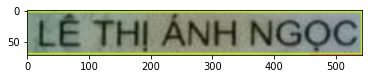

In [4]:
text_img = read_img_as_array('C:/Users/Admin/Desktop/A.N lab/test_imgs-text-regconition/image.png')
print(type(text_img))
print(text_recognition_model.predict(text_img))

plt.imshow(text_img)

- Regconition on patch (with preprocessing)

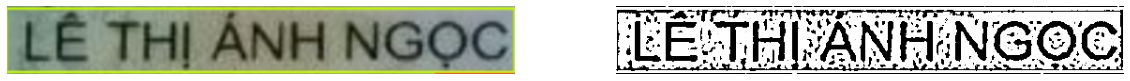

VietOCR predict: lêthánhọc


In [19]:
## Preprocess images by binarize and remove noise from them

# Binarization
def adaptive_threshold_gaussian(img):
    # img = cv2.imread(path)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    new_img = cv2.adaptiveThreshold(gray_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    
    new_img = cv2.merge([new_img, new_img, new_img])
    new_img = Image.fromarray(new_img)
    return new_img

# Noise removal
def noise_removal(image):
    # denoising of image saving it into dst image 
    img = np.asarray(image)
    dst = cv2.fastNlMeansDenoising(img, None, 20,7,21) 

    # return Image.fromarray(dst)
    return dst


noise_remove_img = noise_removal(adaptive_threshold_gaussian(text_img))

### Visualization
list_imgs = [text_img, noise_remove_img]
n = 2
fig = plt.figure(figsize=(20, 20))

for i in range(n):
    ax = fig.add_subplot(1, n, i+1)
    ax.imshow(list_imgs[i])
    ax.axis('off')

plt.show()
print(f'VietOCR predict: {text_recognition_model.predict(text_img)}')

VietOCR predict: ['lê', 'thị', 'ánh', 'ngọc']


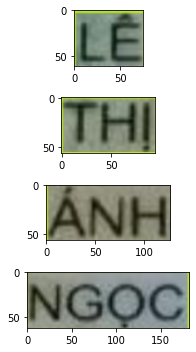

In [34]:
le_img = read_img_as_array('C:/Users/Admin/Desktop/A.N lab/test_imgs-text-regconition/Le.png')
thi_img = read_img_as_array('C:/Users/Admin/Desktop/A.N lab/test_imgs-text-regconition/Thi.png')
anh_img = read_img_as_array('C:/Users/Admin/Desktop/A.N lab/test_imgs-text-regconition/Anh.png')
ngoc_img = read_img_as_array('C:/Users/Admin/Desktop/A.N lab/test_imgs-text-regconition/Ngoc.png')

def preprocess_channel(img):
    # Check if the image has 4 channels (RGBA)
    if len(img.shape) > 2 and img.shape[2] == 4:
        # Convert RGBA to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
    
    return img

list_imgs = [le_img, thi_img, anh_img, ngoc_img]

# preprocess
list_imgs = [preprocess_channel(img) for img in list_imgs]

preds = [text_recognition_model.predict(text_img) for text_img in list_imgs]
# list_imgs.append(le_img)
print(f'VietOCR predict: {preds}')

# Create a figure and subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 5))  # 1 row, 3 columns

# Display images in subplots
ax1.imshow(list_imgs[0])
ax2.imshow(list_imgs[1])
ax3.imshow(list_imgs[2])
ax4.imshow(list_imgs[3])

# Adjust layout (optional)
plt.tight_layout()

# Show the plot
plt.show()

# plt.imshow(name_cropped_img[2])
# len(id_cropped_img)